# Test Attention Mechanism on Simple Sequence Modeling Problem
- Here we use the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb)
- And follow the text classification [tutorial here](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py)
- Aith Attention implemented per the [example here](https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/).

### Import Tensorflow and Check GPU Support

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt

print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Build Vanilla LSTM

In [2]:
def build_model(batch_size, vocab_size, seq_length, embedding_dim=64, rnn_units=128):

    model = Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        input_length=seq_length,
                                        batch_input_shape=[batch_size, None],
                                        name='model1_embedding'))
    
    model.add(tf.keras.layers.LSTM(units=rnn_units,
                                       return_sequences=True,
                                       kernel_regularizer=tf.keras.regularizers.l2(0.1),
                                       recurrent_regularizer=tf.keras.regularizers.l2(0.1),
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### Define Attention Mechanism

In [3]:
class SimpleAttentionMechanism(tf.keras.layers.Layer):
    """
    Simple attention mechanism from: 
    https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/.
    """
    
    def __init__(self, **kwargs):
        
        super(SimpleAttentionMechanism, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        
        super(SimpleAttentionMechanism, self).build(input_shape)

    def call(self, x):
        
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        
        return super(attention, self).get_config()

### Build LSTM with Attention

In [4]:
def build_attention_model(batch_size, vocab_size, seq_length, embedding_dim=64, rnn_units=128):
    """
    Build RNN with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    Note for the tf.keras.LSTM the requirements to use the cuDNN implementation are:

        - activation == tanh
        - recurrent_activation == sigmoid
        - recurrent_dropout == 0
        - unroll is False
        - use_bias is True
        - inputs are not masked or strictly right padded
    
    """
    
    # take inputs of size=seq_length with variable sized elements in the sequence
    model1_input = tf.keras.Input(shape=(seq_length, ),
                                  name='model1_input')
    
    # embed vocab items into embedding_dim dimensional space per sequence element
    model1_embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embedding_dim,
                                                 input_length=seq_length,
                                                 batch_input_shape=[batch_size, None],
                                                 name='model1_embedding')(model1_input)
    
    # apply LSTM to the embdedded input sequence and output rnn_units per sequence element
    model1_lstm = tf.keras.layers.LSTM(units=rnn_units,
                                       return_sequences=True,
                                       kernel_regularizer=tf.keras.regularizers.l2(0.1),
                                       recurrent_regularizer=tf.keras.regularizers.l2(0.1),
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    # compute the attention weights and context vector
    context_vector = SimpleAttentionMechanism()(model1_lstm)
    
    # compute output vector
    output = tf.keras.layers.Dense(units=1)(context_vector)
    
    # define the final model graph's inputs and outputs
    final_model = tf.keras.Model(inputs=model1_input, outputs=output)

    return final_model

### Set Some Parameters for Preprocessing and Training

In [5]:
vocab_size = 20000
seq_length = 80
batch_size = 32
epochs = 15

### Load and Preprocess the Data

In [6]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=seq_length)
x_test = sequence.pad_sequences(x_test, maxlen=seq_length)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


### Fit the Vanilla LSTM

In [7]:
model = build_model(batch_size, vocab_size, seq_length, embedding_dim=32, rnn_units=32)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 38s 2ms/sample - loss: 1.3626 - accuracy: 0.6410 - val_loss: 0.5419 - val_accuracy: 0.7352
Epoch 2/15
25000/25000 [==============================] - 33s 1ms/sample - loss: 0.4825 - accuracy: 0.7778 - val_loss: 0.5498 - val_accuracy: 0.7220
Epoch 3/15
25000/25000 [==============================] - 34s 1ms/sample - loss: 0.4283 - accuracy: 0.8100 - val_loss: 0.5462 - val_accuracy: 0.7323
Epoch 4/15
25000/25000 [==============================] - 35s 1ms/sample - loss: 0.3916 - accuracy: 0.8298 - val_loss: 0.5602 - val_accuracy: 0.7254
Epoch 5/15
25000/25000 [==============================] - 37s 1ms/sample - loss: 0.3623 - accuracy: 0.8448 - val_loss: 0.5984 - val_accuracy: 0.7158
Epoch 6/15
25000/25000 [==============================] - 33s 1ms/sample - loss: 0.3405 - accuracy: 0.8546 - val_loss: 0.6156 - val_accuracy: 0.7142
Epoch 7/15
25000/25000 [==============================] 

### View Performance

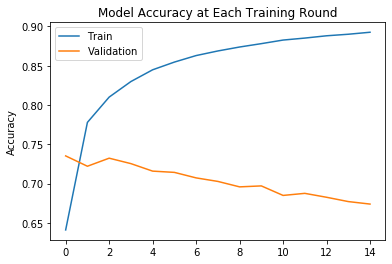

In [8]:
fig, ax = plt.subplots()
x_axis = range(0, epochs)
ax.plot(x_axis, history.history['accuracy'], label='Train')
ax.plot(x_axis, history.history['val_accuracy'], label='Validation')
ax.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Model Accuracy at Each Training Round')
plt.show()

### Fit the LSTM with Attention

In [9]:
model = build_attention_model(batch_size, vocab_size, seq_length, embedding_dim=32, rnn_units=32)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 37s 1ms/sample - loss: 1.4617 - accuracy: 0.7283 - val_loss: 0.5256 - val_accuracy: 0.8226
Epoch 2/15
25000/25000 [==============================] - 35s 1ms/sample - loss: 0.5653 - accuracy: 0.8370 - val_loss: 7.9446 - val_accuracy: 0.5000
Epoch 3/15
25000/25000 [==============================] - 33s 1ms/sample - loss: 7.8674 - accuracy: 0.5000 - val_loss: 7.7880 - val_accuracy: 0.5000
Epoch 4/15
25000/25000 [==============================] - 34s 1ms/sample - loss: 7.7593 - accuracy: 0.5000 - val_loss: 7.7371 - val_accuracy: 0.5000
Epoch 5/15
25000/25000 [==============================] - 35s 1ms/sample - loss: 7.7226 - accuracy: 0.5000 - val_loss: 7.7102 - val_accuracy: 0.5000
Epoch 6/15
25000/25000 [==============================] - 36s 1ms/sample - loss: 7.7010 - accuracy: 0.5000 - val_loss: 7.6930 - val_accuracy: 0.5000
Epoch 7/15
25000/25000 [==============================] 

Test score: 0.9321824161338806
Test accuracy: 0.80676


### View Performance

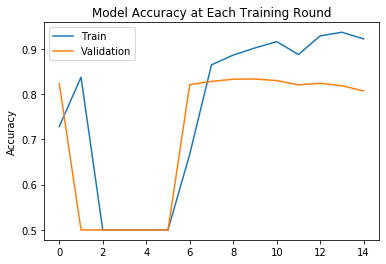

In [10]:
fig, ax = plt.subplots()
x_axis = range(0, epochs)
ax.plot(x_axis, history.history['accuracy'], label='Train')
ax.plot(x_axis, history.history['val_accuracy'], label='Validation')
ax.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Model Accuracy at Each Training Round')
plt.show()